<a href="https://colab.research.google.com/github/mlvlab/COSE474/blob/master/4_Introduction_to_Semantic_Segmentation_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Semantic Segmentation in PyTorch




### Reference
* [PyTorch Tutorial Semantic-Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)
* [Blog: An overview of Semantic-segmentation](https://www.jeremyjordan.me/semantic-segmentation/)
* [CS231N Lecture11: Detection and Segmentation](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)
* [Fully Convolutional Networks paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)


### GOALS
  Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.

1. we will first download a pre-trained weight of segmentation.
2. Then, we will test the network with downloaded image files or your local images


<img src="http://drive.google.com/uc?export=view&id=1dTAPbCKJtwTW1DY6GxCcytCIDfzK_9Nc" width="50%" height="60%">

<img src="http://drive.google.com/uc?export=view&id=1g2rf2HvvWFrUYV7ObHnJIFrWdjd24SP7" width="65%" height="70%">

- A prediction can be collapsed into a segmentation map by taking the argmax of each depth-wise pixel vector

<img src="http://drive.google.com/uc?export=view&id=1exFBUkwh3SqO7w75WtByWGmDkScJs1Ts" width="80%" height="85%">

## Fully Convolutional Networks(FCN)

<img src="http://drive.google.com/uc?export=view&id=1_xiC3JL0soyk0lYu8SmoaksvMheXTDb_" width="75%" height="75%">

Paper Link: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf


<img src="http://drive.google.com/uc?export=view&id=11x4qa4VDtexeHiTBhmRuJhZv8BfM-LX4" width="65%" height="65%">

- Transforming **fully connected layers** into **1x1 convolution layers** enables a classification net to output a heatmap

<img src="http://drive.google.com/uc?export=view&id=1PHsvTq5BPfjcAisZg3ceMkLKMFfZIJR8" width="70%" height="75%">

- image classification networks to serve as the encoder module of the network
- appending a decoder module with **transpose convolutional layers** to upsample the coarse feature maps into a full-resolution segmentation map.

- Fully Convolutional Networks(FCN), are among the most early invented Neural Networks for the task of Semantic Segmentation
- That's it we have a pretrained model of FCN with a Resnet101 backbone


In [0]:
from torchvision import models

fcn = models.segmentation.fcn_resnet101(pretrained=True)

2019-08-23 00:31:02 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


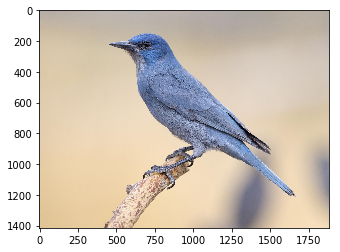

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img_bird = Image.open('./bird.png')
plt.imshow(img_bird); plt.show()

In [0]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp_bird = trf(img_bird).unsqueeze(0) # [1, 3, 224, 224]

In [0]:
# Pass the input through the net
out_bird = fcn(inp_bird)['out']
print(out_bird.shape)

torch.Size([1, 21, 224, 224])


In [0]:
import numpy as np
om_bird = torch.argmax(out_bird.squeeze(), dim=0).detach().cpu().numpy()
print (om_bird.shape)
print (np.unique(om_bird))

(224, 224)
[0 3]


In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

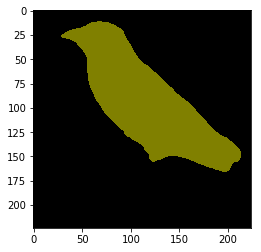

In [0]:
rgb_bird = decode_segmap(om_bird)
plt.imshow(rgb_bird); plt.show()

In [0]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  
  # Pretrained model
  out = net.to(dev)(inp)['out']
  
  # max index for each pixel, which represents the class
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  # Convert 2D image to an RGB image color
  rgb = decode_segmap(om)
  
  plt.imshow(rgb); plt.axis('off'); plt.show()

2019-08-23 00:34:07 URL:https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg [6604923/6604923] -> "horse.png" [1]


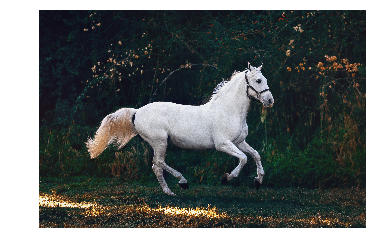

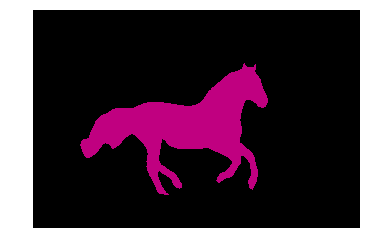

In [0]:
!wget -nv https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg -O horse.png
segment(fcn, './horse.png')

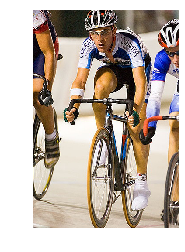

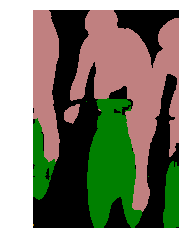

In [0]:
segment(fcn, 'images/2007_000129.jpg')

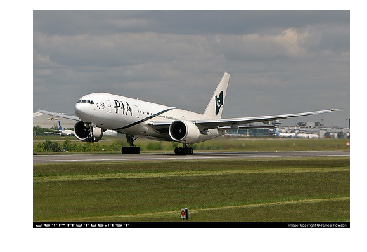

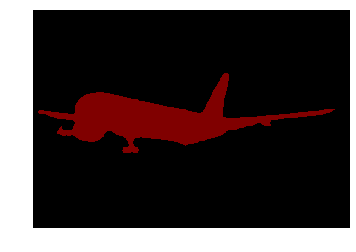

In [0]:
segment(fcn, 'images/2007_000256.jpg')

2019-08-23 01:43:22 URL:https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg [22870459/22870459] -> "person.png" [1]


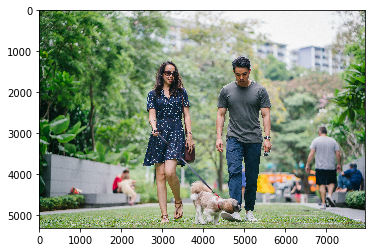

Segmenatation Image on FCN


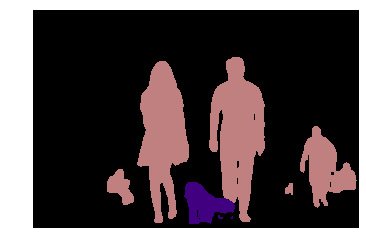

In [0]:
!wget -nv "https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

segment(fcn, path='./person.png', show_orig=False)

- If you want to test with your local images, upload your image. Then test it by following the steps above.

In [0]:
# local image upload
from google.colab import files
image = files.upload()